# <font color='green'>Unrotated surface codes: layout and stabilizers</font>

In [1]:
import cirq
import matplotlib.pyplot as plotter
from matplotlib.patches import Circle, Rectangle
import numpy as np

In this notebook we will visualize the surface code embedded on a 2D nearest-neighbor
grid with data qubits and ancilla qubits. As you have learned before, we cannot directly measure 
the data qubits. As before, in order to detect X and Z errors on the data qubits in such a grid, we will measure a set of 
ancilla qubits. As a reminder, these are known as stabilizer measurements, and the operators measured 
are called stabilizers.

The stabilizers for the surface code we are about to build are
$Z\otimes Z\otimes\ldots\otimes Z$ and $X \otimes X\otimes\ldots\otimes X$.

This chapter is based on [Surface codes: Towards practical large-scale quantum computation](https://arxiv.org/abs/1208.0928).

## <font color='blue'>The layout of the unrotated surface code</font>

We will consider the unrotated planar surface code with open boundary conditions. The qubits are arranged on a 2D lattice. Below, we create a Python class for the planar surface code. You can expand the code cell below to see how it works.

In [2]:
class PlanarSurfaceCode:
    """
    Unrotated planar surface code with respective qubit layout.
    We will use a grid structure showing:
    - Data qubits (D)
    - X ancillas (X)
    - Z ancillas (Z)    
    """
    
    def __init__(self, distance):
        self.distance = distance
        self.data_qubits, self.z_ancillas, self.x_ancillas = self.layout_planar_surface_code(distance)
        self._define_stabilizers()
    
    def layout_planar_surface_code(self, d):
        """
        Layout surface code on a nearest neighbor
        grid.

        """
        data_qubits = {}
        z_anc = {} # qubits for Z stabilizers
        x_anc = {} # qubits for X stabilizers
        for i in range(2 * d - 1):
            for j in range(2 * d - 1):
                if (i + j) % 2 == 0:
                    data_qubits[(i, j)] = cirq.GridQubit(i, j)
                elif i % 2 == 0:
                    z_anc[(i, j)] = cirq.GridQubit(i, j)
                else:
                    x_anc[(i, j)] = cirq.GridQubit(i, j)
        return data_qubits, z_anc, x_anc
    
    def _define_stabilizers(self):
        """
        Define stabilizer generators for the surface code.

        """
        self.x_stabilizers = {}
        self.z_stabilizers = {}
        
        # X stabilizers - each X ancilla measures 4 neighboring data qubits
        for pos in self.x_ancillas:
            i, j = pos
            neighbors = [
                (i-1, j), (i+1, j), (i, j-1), (i, j+1)
            ]
            # Only include neighbors that are data qubits
            data_neighbors = [n for n in neighbors if n in self.data_qubits]
            if data_neighbors:  # Only add if there are valid neighbors
                self.x_stabilizers[pos] = data_neighbors
        
        # Z stabilizers - each Z ancilla measures 4 neighboring data qubits  
        for pos in self.z_ancillas:
            i, j = pos
            neighbors = [
                (i-1, j), (i+1, j), (i, j-1), (i, j+1)
            ]
            # Only include neighbors that are data qubits
            data_neighbors = [n for n in neighbors if n in self.data_qubits]
            if data_neighbors:  # Only add if there are valid neighbors
                self.z_stabilizers[pos] = data_neighbors

    def visualize_layout(self):
        """
        Visualize the surface code layout with data qubits and ancillas.
        
        """
        fig, ax = plotter.subplots(1, 1, figsize=(10, 8))
        
        size = 2 * self.distance - 1
        
        # Draw data qubits
        for pos in self.data_qubits:
            i, j = pos
            color = 'lightblue'
            circle = Circle((j, size-1-i), 0.3, color=color, ec='black', linewidth=2)
            ax.add_patch(circle)
            ax.text(j, size-1-i, 'D', ha='center', va='center', fontweight='bold', fontsize=10)
        
        # Draw X ancillas
        for pos in self.x_ancillas:
            i, j = pos
            color = 'lightgreen'
            
            square = Rectangle((j-0.3/2, size-1-i-0.3/2), 0.3, 0.3, 
                             color=color, ec='black', linewidth=2)
            ax.add_patch(square)
            ax.text(j, size-1-i, 'X', ha='center', va='center', fontweight='bold', fontsize=10)
        
        # Draw Z ancillas
        for pos in self.z_ancillas:
            i, j = pos
            color = 'lightyellow'   
            diamond_x = [j, j+0.15, j, j-0.15, j]
            diamond_y = [size-1-i+0.15, size-1-i, size-1-i-0.15, size-1-i, size-1-i+0.15]
            ax.plot(diamond_x, diamond_y, 'k-', linewidth=2)
            ax.fill(diamond_x, diamond_y, color=color)
            ax.text(j, size-1-i, 'Z', ha='center', va='center', fontweight='bold', fontsize=8)
        
        # Draw stabilizer connections
        for pos, data_qubits_list in self.x_stabilizers.items():
            i, j = pos
            for di, dj in data_qubits_list:
                ax.plot([j, dj], [size-1-i, size-1-di], 'g--', alpha=0.7, linewidth=2)
        
        for pos, data_qubits_list in self.z_stabilizers.items():
            i, j = pos
            for di, dj in data_qubits_list:
                ax.plot([j, dj], [size-1-i, size-1-di], 'y--', alpha=0.7, linewidth=2)
        
        ax.set_xlim(-0.5, size-0.5)
        ax.set_ylim(-0.5, size-0.5)
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
        
        title = f'Distance-{self.distance} Planar Surface Code Layout'
        ax.set_title(title, fontsize=16, fontweight='bold')
        
        legend_elements = [
            Circle((0, 0), 0.1, color='lightblue', ec='black', label='Data Qubit'),
            Rectangle((0, 0), 0.1, 0.1, color='lightgreen', ec='black', label='X Ancilla'),
            Rectangle((0, 0), 0.1, 0.1, color='lightyellow', ec='black', label='Z Ancilla'),
        ]
        
        ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))
        plotter.tight_layout()
        plotter.show()
        
        # Print surface code parameters
        print(f"Surface Code Distance: {self.distance}")
        print(f"Total qubits: {len(self.data_qubits) + len(self.x_ancillas) + len(self.z_ancillas)}")
        print(f"Data qubits: {len(self.data_qubits)}")
        print(f"X ancillas: {len(self.x_ancillas)}")
        print(f"Z ancillas: {len(self.z_ancillas)}")
        print(f"X stabilizers: {len(self.x_stabilizers)}")
        print(f"Z stabilizers: {len(self.z_stabilizers)}")

We can draw an unrotated surface code of distance 3 as follows. Note that the layout has 25 total qubits, with 13 data qubits and 12 ancilla qubits.

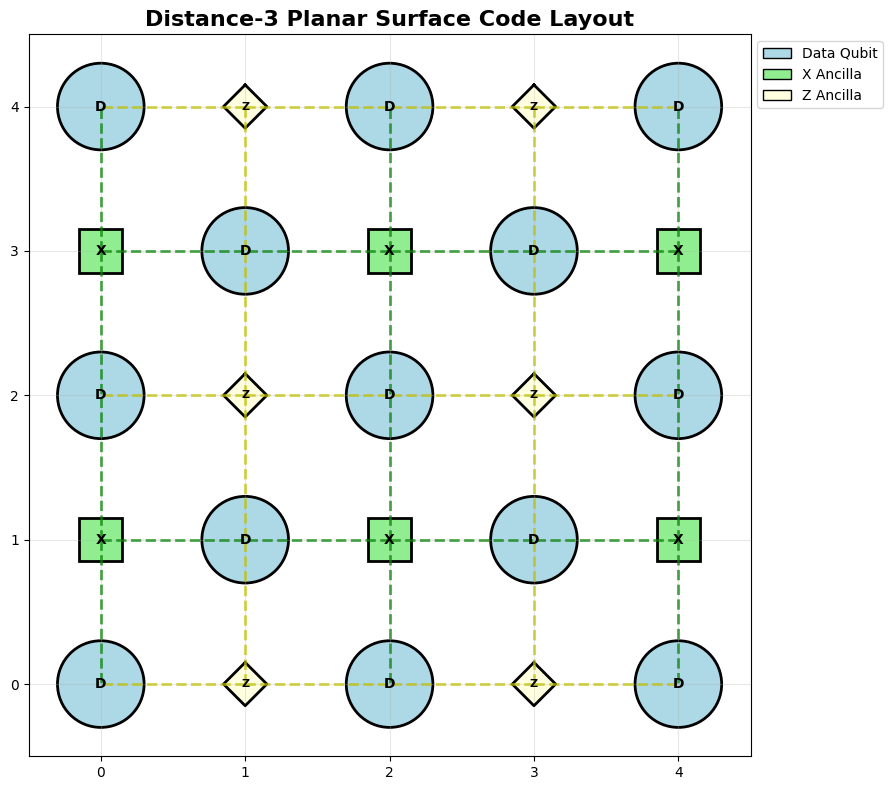

Surface Code Distance: 3
Total qubits: 25
Data qubits: 13
X ancillas: 6
Z ancillas: 6
X stabilizers: 6
Z stabilizers: 6


In [3]:
distance = 3
surface_code = PlanarSurfaceCode(distance)
surface_code.visualize_layout()

In the figure above, the data qubits away from the boundary have four neighboring ancilla 
qubits, while those at the boundary can have two or three ancilla qubits. 

In the bulk of the surface code, each data qubit is connected to two 
$Z$-ancilla qubits and two X-ancilla qubits.

A $Z$-ancilla qubit forces its neighboring data qubits into the eigenstate of the $ZZZZ$ operator. Similarly, 
an $X$-ancilla qubit forces its neighboring data qubits into the eigenstate of the $XXXX$ operator. 

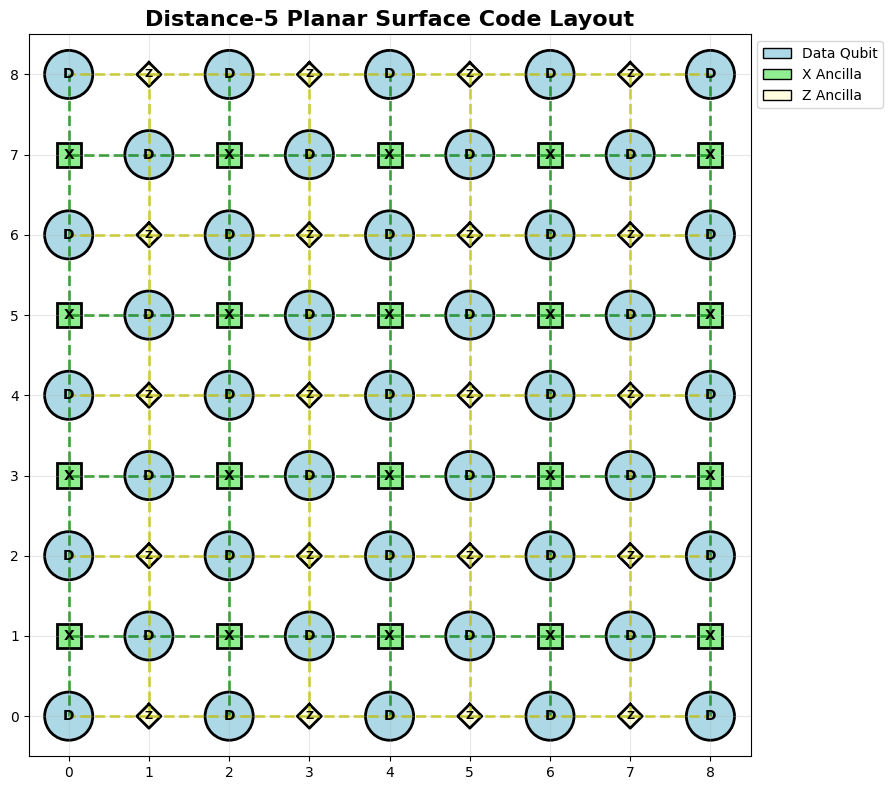

Surface Code Distance: 5
Total qubits: 81
Data qubits: 41
X ancillas: 20
Z ancillas: 20
X stabilizers: 20
Z stabilizers: 20


In [4]:
surface_code = PlanarSurfaceCode(distance=5)
surface_code.visualize_layout()

## <font color='blue'>The rotated surface code</font>

The unrotated surface code above is an example of an $[[n,k,d]]=[[(d^2+(d-1)^2),1,d]]$ stabilizer code. A distance-$d$ surface code encodes 1 logical qubit using $d^2+(d-1)^2$ physical qubits. The unrotated surface code is made up of a total number of $d^2+(d-1)^2 = 2d^2-2d+1$ data qubits and $2\times d\times(d-1) = 2d^2-2d$ ancilla qubits, for a total of $4d^2-4d+1$ physical qubits.

There exists another flavor of surface code known as the rotated planar surface code ($[[n,k,d]]=[[(d^2,1,d]]$). As the name suggests it is a rotated version of the planar surface code by an angle of $45$ degrees. The main advantage of the rotated surface code is that it requires fewer physical qubits ($d^2$ data qubits and $d^2-1$ ancilla qubits for a total of $2d^{2}-1$), saving the need for an additional $2d^2-4d+2$ physical qubits over the unrotated variant.

For additional analysis of the comparison between the two variants, refer to [Compare the Pair: Rotated vs. Unrotated Surface Codes at Equal Logical Error Rates](https://arxiv.org/pdf/2409.14765v1).

**Exercise for the reader**: Modify the Python code above for the unrotated surface code to visualize the rotated variant! 

Now, that you are familiar with the layout of the surface code, we will proceed to 
understanding logical operators on the surface code, and create circuits that will
measure the respective stabilizers. We will learn the meaning of code distance and how
it relates to the logical operators. 

---
### Version History
- v0: Aug 14, 2025, [github/@ESMatekole](https:github.com/esmatekole)
- v1: Sep 12, 2025, [github/@aasfaw](https:github.com/aasfaw)